In [1]:
import numpy as np
import pandas as pd
from astropy.io import ascii
from scipy import stats
from scipy.optimize import minimize,curve_fit
from scipy.stats import gaussian_kde as kde
np.random.seed(9620)

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
sns.set(style='ticks', context='talk')
plt.style.use("../paper.mplstyle")

from multiprocessing import Pool
from tqdm import tqdm

from astropy.cosmology import FlatLambdaCDM
from astropy.coordinates import SkyCoord, Galactic
from astropy import units as u

from warnings import filterwarnings
filterwarnings(action='ignore')

# (0) import data & prepare functions

In [2]:
# import Galaxy data
df_SDSS = pd.read_csv('data/DR8_GZoo+Granada+Portsmouth_cut.csv').set_index('specobjid')
df_MANGA = pd.read_csv('data/MaNGA_combined_v01.csv').set_index('mangaid')
df_CALIFA = pd.read_csv('data/CALIFA_ttype.csv').set_index('califa_id')

In [3]:
# import SN data
data2 = pd.read_csv('data/A2_rev1.csv').set_index('ID')

In [4]:
def get_dist(df,type_range=(),attr='AGE_granada',ttype_attr='gz_ttype',
             gaussian_error=None,slope=None,Nsample=100000,isCALIFA=False):
    '''
    returns a calculated y-values of the kde curve
    inputs:
        type_range: a touple of lower and upper bounds in the types, inclusive
        
    # note: for gaussian error to work, you need the 'slope' value.
    '''
    
    # select binning (e.g. 'early-type')
    idx_lower = np.where(np.asarray(types)==type_range[0])[0][0]
    idx_upper = np.where(np.asarray(types)==type_range[1])[0][0]
    indices = np.arange(idx_lower,idx_upper+1)

    # create weighted disribution
    Ntotal = 0
    y_th = np.zeros(len(x_th))
    for i in indices:
        if isCALIFA:
            cut = df[ttype_attr]==CALIFA_ttypes[i]
            if cut.sum()==0:
                print('error: cannot find ttypes in CALIFA')
                return 1
        else:
            T_lower = T_center[i]-T_ranges[i]
            T_upper = T_center[i]+T_ranges[i]
            cut = (df[ttype_attr]>T_lower) & (df[ttype_attr]<T_upper)
        Ntotal += N_types_A2[i]
        cut = cut & df[attr].notna()
        try:
            y_th += N_types_A2[i] * kde(df[cut][attr].values)(x_th)
        except:
            continue
            
    # normalize
    y_th /= y_th.max()
    
    # gaussian error
    if gaussian_error == None:
        return y_th
    else:
        if slope == None:
            print('error: slope needs to be given')
            return 1
        HR = slope*x_th
        samples   = np.random.choice(HR,Nsample,p=y_th/(y_th.sum()))
        samples_b = [np.random.normal(x,gaussian_error) for x in samples]
        y_th_b = kde(samples_b)(HR)
        y_th_b = y_th_b / y_th_b.max()
        mean = np.mean(samples_b)
        return y_th, y_th_b, mean        

In [5]:
def project_slope(df,slope,slope_err,
                  early_range,late_range,attr,ttype_attr,Nsample=100000,scatter_size=None,isCALIFA=False):
    '''
    projects the galaxy property distribution with specific t-type ranges onto HR space,
    using a SN Ia luminosity -- galaxy property slope.
    
    *** returned data axes ***
     0: slope (min,most_probable,max)
     1: population bin (early or late)
     2: dist, broadened dist, mean of dist
    
    (e.g. results_list[1][0][2] returns 
          the mean of early population in HR space 
          predicted by most probable slope)
    '''
    slope_max = slope-slope_err
    slope_min = slope+slope_err

    results_list = []
    for slope_val in tqdm([slope_min,slope,slope_max]):
        y_early, y_early_b, mean_early = get_dist(df,
                                                  type_range=early_range, attr=attr, ttype_attr=ttype_attr,
                                                  gaussian_error=scatter_size, slope=slope_val, isCALIFA=isCALIFA)
        y_late, y_late_b, mean_late    = get_dist(df,
                                                  type_range=late_range, attr=attr, ttype_attr=ttype_attr,
                                                  gaussian_error=scatter_size, slope=slope_val, isCALIFA=isCALIFA)
        results_list.append([[y_early, y_early_b, mean_early],[y_late, y_late_b, mean_late]])
    

    
    return results_list

# (1) set up (slope, binning, etc.)

In [6]:
slope = -0.036
slope_err = 0.007

In [7]:
# available types and counts
types = ['E','S0-','S0','S0+','S0a','Sa','Sab','Sb','Sbc','Sc','Scd','Sd','Sdm']
T_center = [-5,-3,-2,-1,0,1,2,3,4,5,6,7,8]
T_ranges = [1.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5]
CALIFA_ttypes = [-5,-2,-2,-2,1,1,1,3,4,5,5,7,7]
N_types_A2 = [36,12,21,2,17,28,24,43,34,42,26,2,5]
x_th = np.linspace(-10,30,1000)

# galaxy binning
ttype_early = ('E','S0+')
ttype_late  = ('Sbc','Sdm')

In [8]:
# SN data binning
early_type = ['E', 'E?', 'E/S0', 'S0', 'S0-', 'S0⚬', 'S0+']#, 'S0a', 'Sa'] 
late_type  = ['Sbc','Sc', 'Scd','Sd','Sdm']

# ************ do not need to touch below ***********
# binning
data2['morph_bin'] = np.nan
data2.loc[data2['morphology'].isin(early_type),'morph_bin'] = 'early'
data2.loc[data2['morphology'].isin(late_type),'morph_bin'] = 'late'
bins = np.linspace(-1,1,50)
early = data2['morph_bin']=='early'
late = data2['morph_bin']=='late'

# error sampling
Nsample = 100000
SN_early = np.array([np.random.normal(data2[early]['HR'][i],data2[early]['HR_err'][i],Nsample) for i in range(early.sum())]).flatten()
SN_late = np.array([np.random.normal(data2[late]['HR'][i],data2[late]['HR_err'][i],Nsample) for i in range(late.sum())]).flatten()
HR_err_mean = data2['HR_err'].mean()
# ***************************************************

# (2) do analysis

In [9]:
df_MANGA.columns

Index(['dl_ttype', 'ff_age_lw', 'ff_age_mw', 'ff_mass', 'gz_p_dominant',
       'gz_p_nobulge', 'gz_p_obvious', 'gz_ttype', 'p3d_age_lw', 'p3d_age_mw',
       'p3d_mass', 'plateifu', 'z'],
      dtype='object')

In [10]:
df_SDSS.columns

Index(['AGE_granada', 'AGE_portsmouth', 'LOGMASS_granada',
       'LOGMASS_portsmouth', 'Z_granada', 'Z_portsmouth', 'p_dominant',
       'p_nobulge', 'p_obvious', 'gz_ttype'],
      dtype='object')

In [11]:
df_CALIFA.columns

Index(['mass', 'age_lw', 'age_mw', 'ttype'], dtype='object')

In [12]:
R19_firefly = project_slope(df_MANGA,slope,slope_err,
                            ttype_early,ttype_late,
                            attr = 'ff_age_mw',
                            ttype_attr = 'gz_ttype',
                            scatter_size = HR_err_mean
                           )

100%|██████████| 3/3 [00:14<00:00,  4.81s/it]


In [13]:
R19_pipe3d = project_slope(df_MANGA,slope,slope_err,
                            ttype_early,ttype_late,
                            attr = 'p3d_age_mw',
                            ttype_attr = 'gz_ttype',
                            scatter_size = HR_err_mean
                           )

100%|██████████| 3/3 [00:15<00:00,  5.24s/it]


In [14]:
R19_granada = project_slope(df_SDSS,slope,slope_err,
                            ttype_early,ttype_late,
                            attr = 'AGE_granada',
                            ttype_attr = 'gz_ttype',
                            scatter_size = HR_err_mean
                           )

100%|██████████| 3/3 [00:21<00:00,  7.21s/it]


In [15]:
R19_portsmouth = project_slope(df_SDSS,slope,slope_err,
                            ttype_early,ttype_late,
                            attr = 'AGE_portsmouth',
                            ttype_attr = 'gz_ttype',
                            scatter_size = HR_err_mean
                           )

100%|██████████| 3/3 [00:21<00:00,  7.10s/it]


In [16]:
R19_Starlight = project_slope(df_CALIFA,slope,slope_err,
                            ttype_early,ttype_late,
                            attr = 'age_mw',
                            ttype_attr = 'ttype',
                            scatter_size = HR_err_mean,
                            isCALIFA = True
                           )

100%|██████████| 3/3 [00:14<00:00,  4.97s/it]


In [17]:
with open('data/R19.npy', 'wb') as f:
    np.save(f, np.asarray(R19_granada),allow_pickle=True)
    np.save(f, np.asarray(R19_portsmouth),allow_pickle=True)
    np.save(f, np.asarray(R19_firefly),allow_pickle=True)
    np.save(f, np.asarray(R19_pipe3d),allow_pickle=True)
    np.save(f, np.asarray(R19_Starlight),allow_pickle=True)
    np.save(f, SN_early,allow_pickle=True)
    np.save(f, SN_late,allow_pickle=True)

# (4) plot results

In [18]:
def plot_results(results,x_th,slope,color='yellowgreen',plot_early=True,plot_late=False,ax=None,label=None,
                plot_axvline=False,plot_errorbar=True,yscale=1,ls=':',errorbar_yloc=0.3):
    # data prep
    HR = x_th*slope
    offset = results[1][1][2]
    mean_min = results[2][0][2] - results[2][1][2]
    mean_mpb = results[1][0][2] - results[1][1][2]
    mean_max = results[0][0][2] - results[0][1][2]
    early_dist_b = results[1][0][1]
    late_dist_b = results[1][1][1]
    
    if ax==None:
        ax = plt.gca()
    if plot_early:
        ax.plot(HR-offset,early_dist_b*yscale,c=color,lw=3,alpha=0.8,label=label)
    if plot_late:
        ax.plot(HR-offset,late_dist_b*yscale,c='lightblue',lw=3,alpha=0.8,label=label)

    if plot_axvline:
        ax.axvline(mean_mpb,linestyle=ls,color=color,alpha=1,lw=3,zorder=10)
        ax.axvspan(mean_min,mean_max,color=color,alpha=0.05)
    if plot_errorbar:
        err_min = mean_min-mean_mpb
        err_max = mean_mpb-mean_max
        ax.errorbar(mean_mpb,errorbar_yloc,xerr=[[err_min],[err_max]], fmt='o', 
                    color=color, ecolor=color, ms=7,lw=3,capsize=7)

([], <a list of 0 Text major ticklabel objects>)

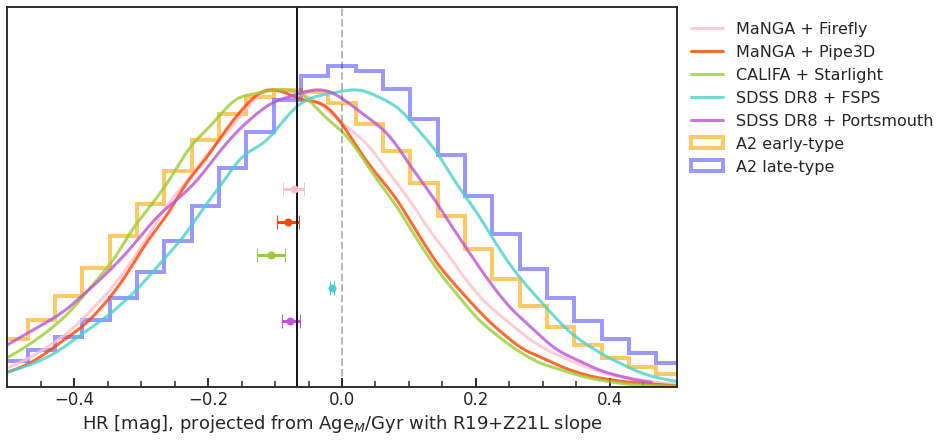

In [19]:
fig, ax = plt.subplots(1,1,figsize=(12,7))

y1,_,_ = plt.hist(SN_early-SN_late.mean(),color='orange',bins=bins,density=True,alpha=0.6,label='A2 early-type',histtype=u'step',lw=4)
y2,_,_ = plt.hist(SN_late-SN_late.mean(),color='blue',bins=bins,density=True,alpha=0.4,label='A2 late-type',histtype=u'step',lw=4)

plot_results(R19_firefly,x_th,slope,yscale=y1.max(),color='pink',label='MaNGA + Firefly',ls='dotted',errorbar_yloc=1.2)
plot_results(R19_pipe3d,x_th,slope,yscale=y1.max(),color='orangered',label='MaNGA + Pipe3D',ls='dashed',errorbar_yloc=1.0)
plot_results(R19_Starlight,x_th,slope,yscale=y1.max(),color='yellowgreen',label='CALIFA + Starlight',ls=(0, (3, 1, 1, 1, 1, 1)),errorbar_yloc=0.8)
plot_results(R19_granada,x_th,slope,yscale=y1.max(),color='mediumturquoise',label='SDSS DR8 + FSPS',ls='dashdot',errorbar_yloc=0.6)
plot_results(R19_portsmouth,x_th,slope,yscale=y1.max(),color='mediumorchid',label='SDSS DR8 + Portsmouth',ls='dashdot',errorbar_yloc=0.4)

plt.axvline(SN_early.mean()-SN_late.mean(),linestyle='-',c='k',lw=2)
plt.axvline(0,linestyle='--',c='k',lw=2,alpha=0.3)

plt.xlabel(r'HR [mag], projected from Age$_M/$Gyr with R19+Z21L slope')
plt.legend(ncol=1,bbox_to_anchor=[1,1],loc='upper left')
plt.xlim(-0.5,0.5)
plt.ylim(0,2.3)
plt.yticks([])

In [20]:
0.006/0.036

0.16666666666666669